##Google Colab import file, ignore when run local


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir drive
!google-drive-ocamlfuse drive

##Referemce: https://github.com/tegg89/SRCNN-Tensorflow


In [0]:
import tensorflow as tf
import numpy as np
import os
import glob
import time
import scipy.misc
import scipy.ndimage
from PIL import Image 
import cv2
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

##Tunning parameter & Define the weight and bias for CNN

In [0]:
# define SRCNN

batch_size = 128
img_size = 33
channel_size = 3
label_size = 21
learning_rate = 1e-4
dataset_dir = './drive/ADS_CNN/train_set/LR'
testset_dir = './drive/ADS_CNN/train_set/HR'
sample_dir = './drive/ADS_CNN/train_set/sample'
epochs = 100
scale = 3
stride = 14 
padding = 6
save_model_name = "SRCNN.model"
checkpoint_dir = "checkpoints"



weights = {
    'w1':tf.Variable(tf.random_normal([9,9,channel_size,64], stddev=1e-3),name='w1'),
    'w2':tf.Variable(tf.random_normal([1,1,64,32], stddev=1e-3), name='w2'),
    'w3':tf.Variable(tf.random_normal([5,5,32,channel_size], stddev=1e-3), name='w3')
}

bias = {
    'b1':tf.Variable(tf.zeros([64]),name='b1'),
    'b2':tf.Variable(tf.zeros([32]), name='b2'),
    'b3':tf.Variable(tf.zeros([channel_size]), name='b3')
}

inputs = tf.placeholder(tf.float32,[None,img_size, img_size,channel_size],name='inputs')
labels = tf.placeholder(tf.float32,[None,label_size,label_size,channel_size],name='labels')



conv1 = tf.nn.relu(tf.nn.conv2d(inputs,weights['w1'],strides=[1,1,1,1],padding='VALID')+bias['b1'])
conv2 = tf.nn.relu(tf.nn.conv2d(conv1,weights['w2'],strides=[1,1,1,1],padding='VALID')+bias['b2'])
conv3 = tf.nn.relu(tf.nn.conv2d(conv2,weights['w3'],strides=[1,1,1,1],padding='VALID')+bias['b3'])

pred=conv3
loss = tf.reduce_mean(tf.square(labels-conv3))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

## Use 31X31 as the input and 21X21 as the label

In [0]:
# define prepocess

def read_data(train_dir,stride):
    # get data
    filenames = os.listdir(train_dir)
    data_dir = os.path.join(os.getcwd(), train_dir)
    data = glob.glob(os.path.join(data_dir, "*.jpg"))
    sub_input_sequence = []
    sub_label_sequence = []
    sub_input_nx=[]
    sub_input_ny=[]

    for idx in range(len(data)):
        input_, label_ = load_data(data[idx], scale)
        h, w,c = input_.shape
        nx=0
        ny=0
        for x in range(0, h - img_size + 1, stride):
            nx+=1
            ny=0
            for y in range(0, w - img_size + 1, stride):
                # print(x,x + img_size)
                ny+=1
                sub_input = input_[x:x + img_size, y:y + img_size]  # [33,33]
                sub_label = label_[x + padding:x + padding + label_size,
                            y + padding:y + padding + label_size]  # [21,21] label

                sub_input = sub_input.reshape([img_size, img_size, channel_size])
                sub_label = sub_label.reshape([label_size, label_size, channel_size])

                sub_input_sequence.append(sub_input)
                sub_label_sequence.append(sub_label)

        sub_input_nx.append(nx)
        sub_input_ny.append(ny)
    return sub_input_sequence, sub_label_sequence,sub_input_nx,sub_input_ny


def load_data(data_path, scale=3):
    img = cv2.imread(data_path)
#     img = scipy.misc.imread(data_path, flatten=True, mode='YCbCr').astype(np.float)
    label_ = modcrop(img, scale=3)  #
    img = img / 255.
    label_ = label_ / 255.
    input_ = scipy.ndimage.interpolation.zoom(label_, (1. / scale), prefilter=False)
    input_ = scipy.ndimage.interpolation.zoom(input_, (scale / 1.), prefilter=False)
#     bicbuic_img = cv2.resize(label_,None,fx = 1.0/scale ,fy = 1.0/scale, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
#     input_ = cv2.resize(bicbuic_img,None,fx = scale ,fy=scale, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
    return input_, label_


def modcrop(image, scale=3):
    """
    To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
    """
    if len(image.shape) == 3:
        h, w, _ = image.shape
#         h = h - np.mod(h, scale)
#         w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image



def merge(images, size, c_dim):
    """
        images is the sub image set, merge it
    """
    h, w = images.shape[1], images.shape[2]
    
    img = np.zeros((h*size[0], w*size[1], c_dim))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j * h : j * h + h,i * w : i * w + w, :] = image
        #cv2.imshow("srimg",img)
        #cv2.waitKey(0)
        
    return img
  
# def array_image_save(array, image_path):
#   """
#   Converts np array to image and saves it
#   """
#   image = Image.fromarray(array)
#   if image.mode != 'RGB':
#     image = image.convert('RGB')
#   image.save(image_path)
#   print("Saved image: {}".format(image_path))


 
  

In [0]:
# get the data for train
train_data, train_label, nx,ny = read_data(dataset_dir,stride)

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [0]:
np.shape(train_data)

(24132, 33, 33, 3)

##Start trainning and testing

In [0]:
# start training

print("Start training......")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        start_time = time.time()
        batch_idxs = len(train_data)//batch_size
        epoch_error = []
        for idx in range(batch_idxs):
            batch_images = train_data[idx*batch_size:(idx+1)*batch_size]
            # print(batch_images.shape)
            batch_labels = train_label[idx*batch_size:(idx+1)*batch_size]
            _, batch_loss,batch_conv3 = sess.run([train_op,loss,conv3],feed_dict={inputs:batch_images,labels:batch_labels})
            epoch_error.append(batch_loss)
            '''
            if idx %10 == 0:
                print("Epoch: [%d], batch: [%d], loss: [%f]" % (epoch,idx,batch_loss))
            '''
           
        if epoch % 10 == 0:
            print("Epoch: [%d], Time: [%4.2f], Loss: [%f]" % (epoch,time.time()-start_time,np.mean(epoch_error)))
            
    
    print("Start testing......")
    test_data, test_label, nx, ny = read_data(testset_dir, stride=21)
    _, test_conv3 = sess.run([train_op, conv3],
                             feed_dict={inputs: test_data, labels: test_label})
    filenames = os.listdir(testset_dir)
    data_dir = os.path.join(os.getcwd(), testset_dir)
    data = glob.glob(os.path.join(data_dir, "*.jpg"))
    for idx in range(len(data)):
        test_input_, test_label_ = load_data(data[idx], scale)
        result = merge(test_conv3[0:nx[idx]*ny[idx]], [nx[idx], ny[idx]],3)
        test_conv3 = test_conv3[nx[idx]*ny[idx]:]
#         result = result.squeeze()  # to squeeze to one channel


#         plt.figure(figsize=(20,20))
#         plt.subplot(1,3,1)
#         plt.imshow(test_input_)
#         plt.title("Input")
#         plt.subplot(1,3,2)
#         plt.imshow(result)
#         plt.title("Output")
#         plt.subplot(1,3,3)
#         plt.imshow(test_label_)
#         plt.title("Label")
#         plt.show()
        num=idx+1
        image_path = os.path.join(os.getcwd(), sample_dir)
        image_path = os.path.join(image_path, "test_image_%d_output.jpg" % num)
        cv2.imwrite(image_path, test_label_ * 255.)  # imwrite range(0,255)


    print("Start saving......")
    saver = tf.train.Saver()
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    saver.save(sess, os.path.join(checkpoint_dir, save_model_name))
    print("Finish!")


Start training......
Epoch: [0], Time: [0.68], Loss: [0.227801]
Epoch: [10], Time: [0.53], Loss: [0.020200]
Epoch: [20], Time: [0.53], Loss: [0.019292]
Epoch: [30], Time: [0.53], Loss: [0.018327]
Epoch: [40], Time: [0.52], Loss: [0.017488]
Epoch: [50], Time: [0.53], Loss: [0.016963]
Epoch: [60], Time: [0.53], Loss: [0.016714]
Epoch: [70], Time: [0.53], Loss: [0.016596]
Epoch: [80], Time: [0.52], Loss: [0.016526]
Epoch: [90], Time: [0.52], Loss: [0.016476]
Start testing......


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Start saving......
Finish!


Populating the interactive namespace from numpy and matplotlib


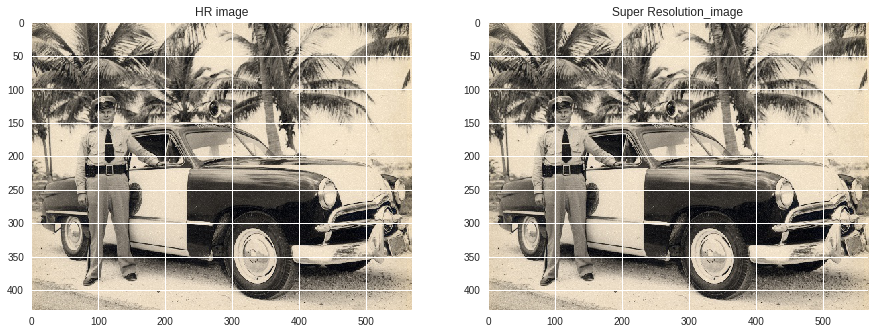

In [0]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('./drive/ADS_CNN/train_set/HR/img_0001.jpg')
img_sample=mpimg.imread('./drive/ADS_CNN/train_set/sample/test_image_1_output.jpg')
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("HR image")
plt.subplot(1,2,2)
plt.imshow(img_sample)
plt.title("Super Resolution_image")
plt.show()


##Calculating PSNR

In [0]:
image_dir = os.path.join(os.getcwd(), sample_dir)
sample = glob.glob(os.path.join(image_dir, "*.jpg"))

In [0]:
import numpy
import math

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


In [0]:
psnr_out=[]
for i in range(len(data)):
  psnr_out.append(psnr(cv2.imread(data[i]),cv2.imread(sample[i])))
mean(psnr_out)
  

50.5901796238244